In [1]:
import numpy as np
import suite2p
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Sequence, Dict, Any
from scipy.stats import kde, pearsonr
import numpy as np
import pandas as pd
import os
import pickle
from scipy.signal import find_peaks
import cottage_analysis as cott
from cottage_analysis.imaging.common import align_timestamps, find_frames

from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy
import motion_model as mm
from motion_model.util import lag_tensor
import jax
import jax.numpy as jnp
import numpy as np
import haiku as hk
import graphviz
import optax


# Simulation

In [2]:
# Generate random running speeds --> optic flow
time = 1000
frame_rate = 30
mean_speed = 15  #cm/s
std_speed = 3
depth_list = [20, 63, 200]  #cm
all_depths = np.repeat(depth_list,int(time*frame_rate/len(depth_list)))

speeds = np.random.normal(loc=mean_speed, scale=std_speed, size=time*frame_rate)


In [3]:
# Process RS & OF arrays
# Thresholding
def thr(arr, thr):
    arr[arr<thr] = thr    
    return arr
speeds = thr(speeds, thr=0.01)
# optics = np.degrees(speeds/all_depths)  #degrees
optics = speeds/all_depths

#Lag
rs_lag_min = -0.5
rs_lag_max = 1
of_lag_min = 0
of_lag_max = 1

rs_lags = lag_tensor(speeds, nlags_min=int(frame_rate*rs_lag_min), nlags_max = int(frame_rate*rs_lag_max))
of_lags = lag_tensor(optics, nlags_min=int(frame_rate*of_lag_min), nlags_max = int(frame_rate*of_lag_max))

#Log
rs_x = np.log(rs_lags)
of_x = np.log(of_lags)

Text(0.5, 1.0, 'Gaussian kernel for log(OF)')

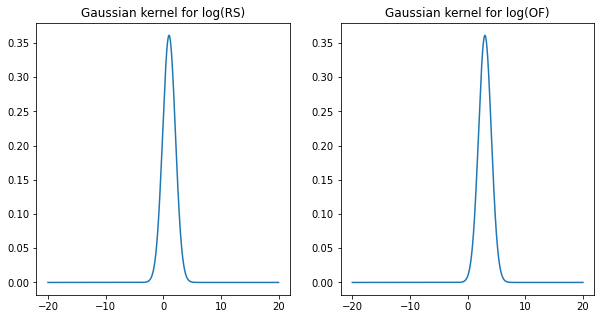

In [4]:
# Gaussian
rs_mu = 1
rs_log_sigma = 0.1
of_mu = 3
of_log_sigma = 0.1

def _gaussian(x):
    module = mm.modules.GaussianModule(output_size=1)
    return module(x)

def initialize_model_params(model, rng_key, x, modules, set_params_name, set_params_value):
    params = model.init(rng=rng_key, x=x)
    params_dict = hk.data_structures.to_mutable_dict(params)
    for module in modules:
        for set_param_name, set_param_value in zip(set_params_name, set_params_value):
            params_dict[module][set_param_name] = jnp.array(set_param_value, dtype=jnp.float32)
    params = hk.data_structures.to_immutable_dict(params_dict)
    
    return params

forward_gaussian = hk.without_apply_rng(hk.transform(_gaussian))
rng_key = jax.random.PRNGKey(42)
params_rs_gaussian = initialize_model_params(model=forward_gaussian, rng_key=rng_key, x=rs_x, 
                                    modules=['gaussian_module'], 
                                    set_params_name=['mu','log_sigma'], 
                                    set_params_value=[[rs_mu], [rs_log_sigma]])
rs_gaussian = forward_gaussian.apply(params=params_rs_gaussian, x=rs_x)
params_of_gaussian = initialize_model_params(model=forward_gaussian, rng_key=rng_key, x=of_x, 
                                    modules=['gaussian_module'], 
                                    set_params_name=['mu','log_sigma'], 
                                    set_params_value=[[of_mu], [of_log_sigma]])
of_gaussian = forward_gaussian.apply(params=params_of_gaussian, x=of_x)

x_axis = np.arange(-20,20,0.001)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(x_axis, scipy.stats.norm.pdf(x_axis, rs_mu, np.power(np.e,rs_log_sigma)))
plt.title('Gaussian kernel for log(RS)')

plt.subplot(1,2,2)
plt.plot(x_axis, scipy.stats.norm.pdf(x_axis, of_mu, np.power(np.e,of_log_sigma)))
plt.title('Gaussian kernel for log(OF)')

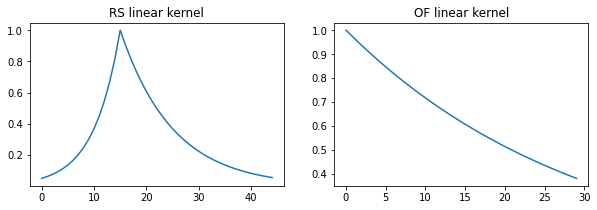

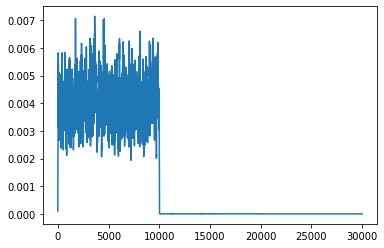

In [5]:
# Linear 
# RS linear kernel
N=1
rs_t1 = np.arange(np.abs(rs_lag_min)*frame_rate,0,-1)
rs_tau1 = 5
rs_N = 1
rs_k1 = N * np.exp(-rs_t1/rs_tau1)
rs_t2 = np.arange(np.abs(rs_lag_max)*frame_rate)
rs_tau2 = 10
rs_k2 = N * np.exp(-rs_t2/rs_tau2)
rs_k = np.concatenate((rs_k1, rs_k2))

# OF linear kernel
of_t1 = np.arange(np.abs(of_lag_min)*frame_rate,0,-1)
of_tau1 = 5
of_N = 1
of_k1 = N * np.exp(-of_t1/of_tau1)
of_t2 = np.arange(np.abs(of_lag_max)*frame_rate)
of_tau2 = 30
of_k2 = N * np.exp(-of_t2/of_tau2)
of_k = np.concatenate((of_k1, of_k2))

plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(rs_k)
plt.title('RS linear kernel')
plt.subplot(1,2,2)
plt.plot(of_k)
plt.title('OF linear kernel')

rs_b = 0
rs_k = rs_k
of_b = 0
of_k = of_k
def _linear(x):
    module = hk.Linear(output_size=1)
    return module(x)
linear_model = hk.without_apply_rng(hk.transform(_linear))
rng_key = jax.random.PRNGKey(42)
params_rs_linear = initialize_model_params(model=linear_model, rng_key=rng_key, x=rs_gaussian, 
                                    modules=['linear'], 
                                    set_params_name=['b','w'], 
                                    set_params_value=[[rs_b], rs_k.reshape(-1,1)])

params_of_linear = initialize_model_params(model=linear_model, rng_key=rng_key, x=of_gaussian, 
                                    modules=['linear'], 
                                    set_params_name=['b','w'], 
                                    set_params_value=[[of_b], of_k.reshape(-1,1)])

rs_linear = linear_model.apply(params=params_rs_linear, x=rs_gaussian)
of_linear = linear_model.apply(params=params_of_linear, x=of_gaussian)

params_rs_linear = linear_model.init(rng=rng_key, x=rs_gaussian)
plt.figure()
plt.plot(of_linear)

In [6]:
# Integrate
dff = np.exp((rs_linear+of_linear))


Text(0.5, 1.0, 'dff')

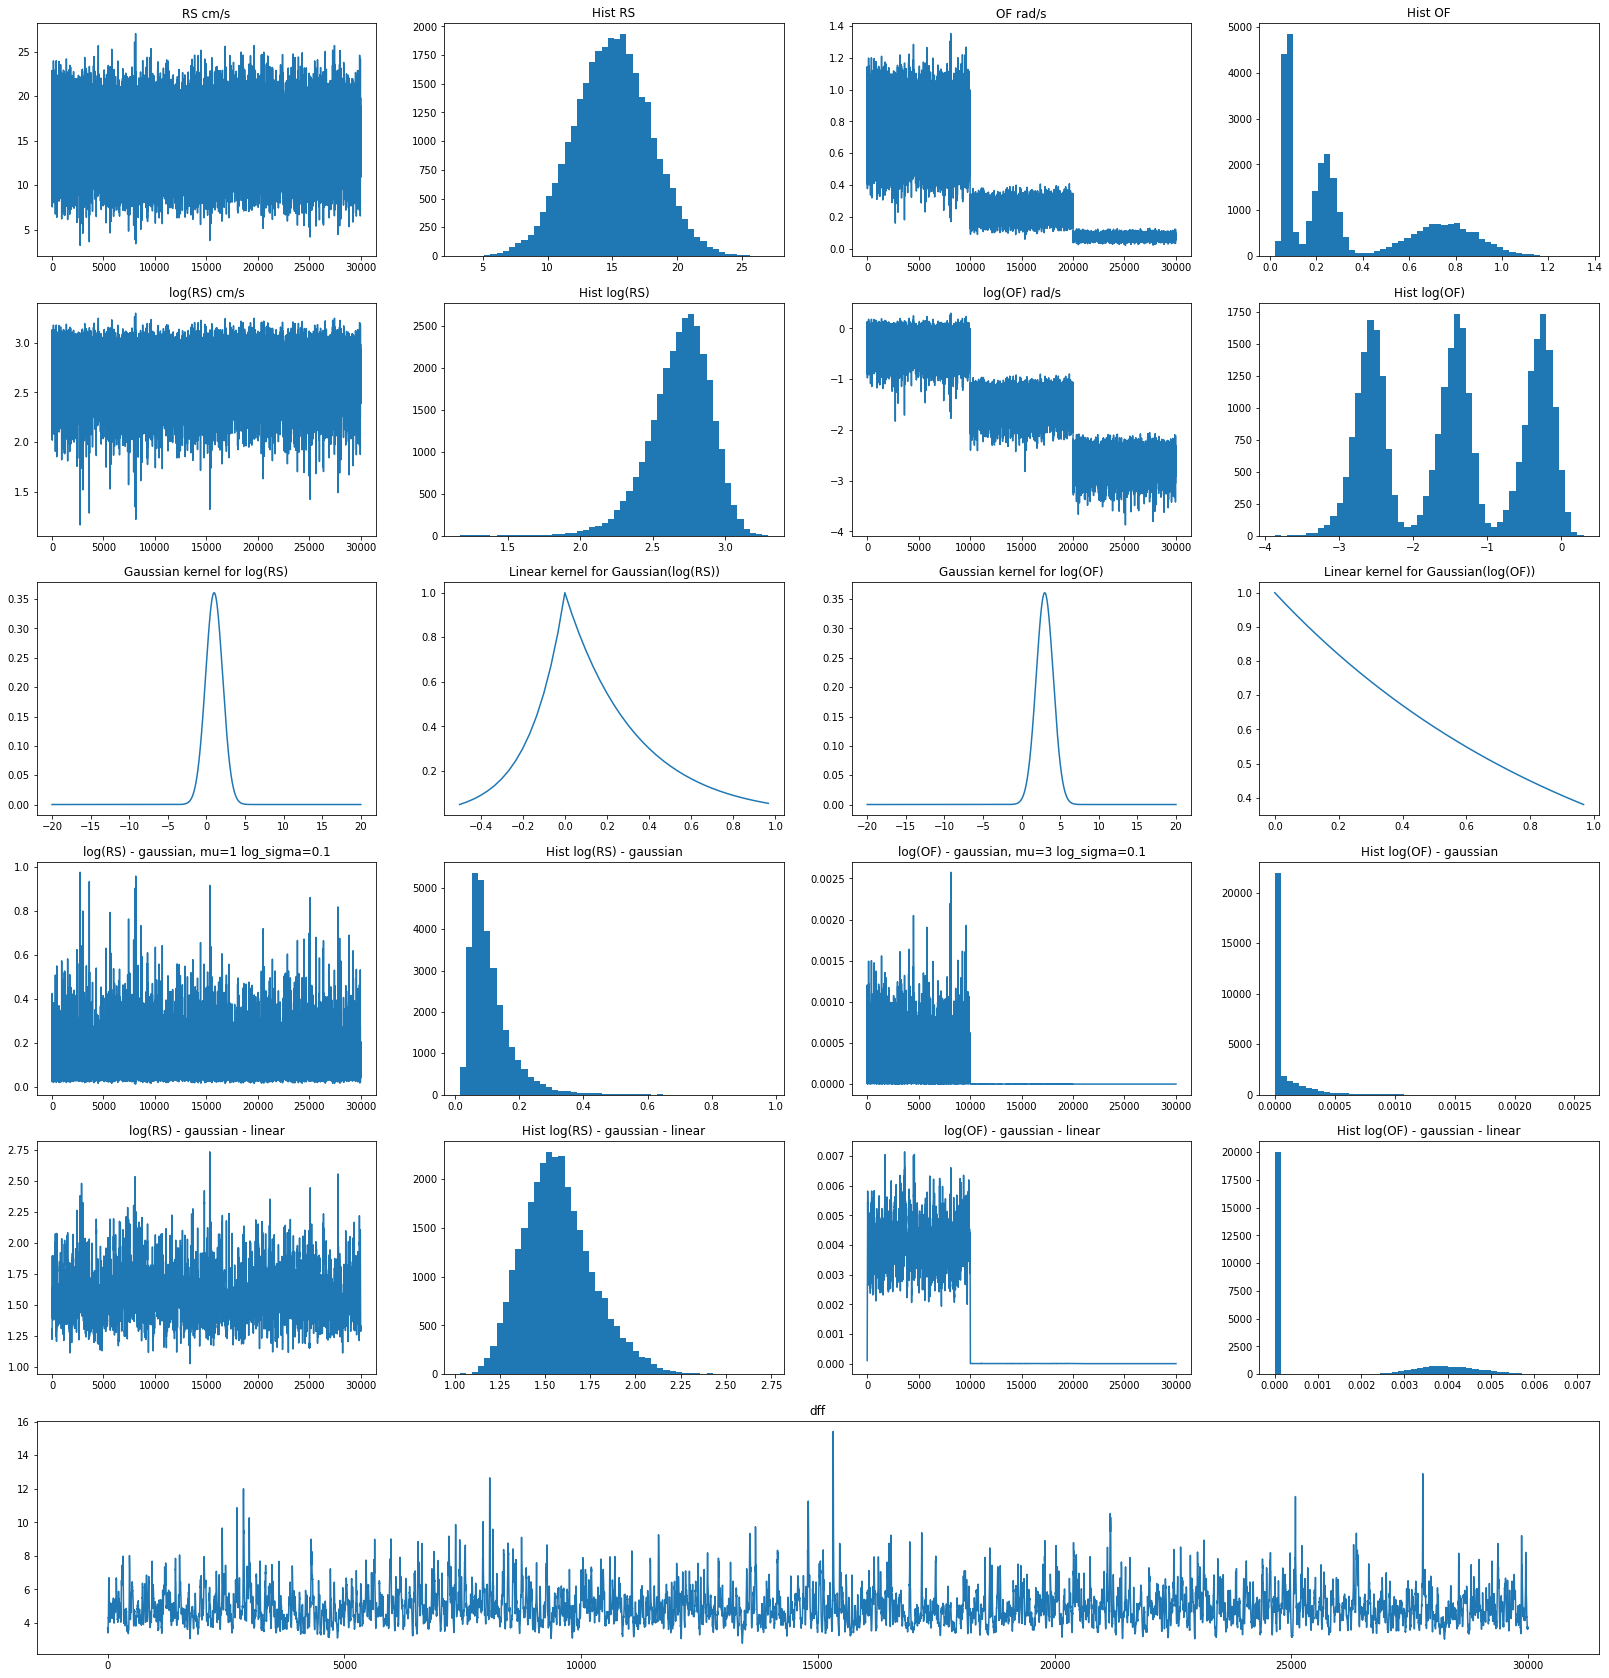

In [7]:
plot_rows = 6
plot_cols = 4
plot_start = 0
plot_end = 1000

plt.figure(figsize=(7*plot_cols,5*plot_rows))
plt.subplot2grid([plot_rows,plot_cols],[0,0])
plt.plot(speeds)
plt.title('RS cm/s')

plt.subplot2grid([plot_rows,plot_cols],[0,1])
plt.hist(speeds,bins=50)
plt.title('Hist RS')

plt.subplot2grid([plot_rows,plot_cols],[1,0])
plt.plot(np.log(speeds))
plt.title('log(RS) cm/s')

plt.subplot2grid([plot_rows,plot_cols],[1,1])
plt.hist(np.log(speeds),bins=50)
plt.title('Hist log(RS)')

plt.subplot2grid([plot_rows,plot_cols],[0,2])
plt.plot(optics)
plt.title('OF rad/s')

plt.subplot2grid([plot_rows,plot_cols],[0,3])
plt.hist(optics,bins=50)
plt.title('Hist OF')

plt.subplot2grid([plot_rows,plot_cols],[1,2])
plt.plot(np.log(optics))
plt.title('log(OF) rad/s')

plt.subplot2grid([plot_rows,plot_cols],[1,3])
plt.hist(np.log(optics),bins=50)
plt.title('Hist log(OF)')

plt.subplot2grid([plot_rows,plot_cols],[2,0])
x_axis = np.arange(-20,20,0.001)
plt.plot(x_axis, scipy.stats.norm.pdf(x_axis, rs_mu, np.power(np.e,rs_log_sigma)))
plt.title('Gaussian kernel for log(RS)')

plt.subplot2grid([plot_rows,plot_cols],[2,1])
plt.plot(np.arange(len(rs_k))/frame_rate-np.abs(rs_lag_min), rs_k)
plt.title('Linear kernel for Gaussian(log(RS))')

plt.subplot2grid([plot_rows,plot_cols],[2,2])
plt.plot(x_axis, scipy.stats.norm.pdf(x_axis, of_mu, np.power(np.e,of_log_sigma)))
plt.title('Gaussian kernel for log(OF)')

plt.subplot2grid([plot_rows,plot_cols],[2,3])
plt.plot(np.arange(len(of_k))/frame_rate-np.abs(of_lag_min), of_k)
plt.title('Linear kernel for Gaussian(log(OF))')

plt.subplot2grid([plot_rows,plot_cols],[3,0])
plt.plot(rs_gaussian[:,int(np.abs(rs_lag_min)*frame_rate)])
plt.title('log(RS) - gaussian, mu='+str(rs_mu)+' log_sigma='+str(rs_log_sigma))

plt.subplot2grid([plot_rows,plot_cols],[3,1])
plt.hist(np.array(rs_gaussian[:,int(np.abs(rs_lag_min)*frame_rate)]),bins=50)
plt.title('Hist log(RS) - gaussian')

plt.subplot2grid([plot_rows,plot_cols],[3,2])
plt.plot(of_gaussian[:,int(np.abs(of_lag_min)*frame_rate)])
plt.title('log(OF) - gaussian, mu='+str(of_mu)+' log_sigma='+str(of_log_sigma))

plt.subplot2grid([plot_rows,plot_cols],[3,3])
plt.hist(np.array(of_gaussian[:,int(np.abs(of_lag_min)*frame_rate)]),bins=50)
plt.title('Hist log(OF) - gaussian')

plt.subplot2grid([plot_rows,plot_cols],[4,0])
# plt.plot(rs_linear[plot_start:plot_end])
plt.plot(rs_linear)
plt.title('log(RS) - gaussian - linear')

plt.subplot2grid([plot_rows,plot_cols],[4,1])
plt.hist(np.array(rs_linear),bins=50)
plt.title('Hist log(RS) - gaussian - linear')

plt.subplot2grid([plot_rows,plot_cols],[4,2])
# plt.plot(of_linear[plot_start:plot_end])
plt.plot(of_linear)
plt.title('log(OF) - gaussian - linear')

plt.subplot2grid([plot_rows,plot_cols],[4,3])
plt.hist(np.array(of_linear),bins=50)
plt.title('Hist log(OF) - gaussian - linear')

plt.subplot2grid([plot_rows,plot_cols],[5,0], colspan=4)
plt.plot(dff)
plt.title('dff')



# Model fitting

In [8]:
seed=42
lr=1e-2
nepoches = 3
batch_size = 1000

rs_x = rs_x
of_x = of_x
spikes = jnp.array(dff, dtype=jnp.float32)
nbatches = int(np.ceil(len(spikes)/batch_size))
loss_history = []
grads_history = []

# Initialization
rng_key = jax.random.PRNGKey(seed)
params = mm.model.rs_of_integration.init(rng=rng_key, rs=rs_x, of=of_x)
opt = optax.adam(lr)
opt_state = opt.init(params)

# Stratify data 
from random import shuffle
def stratify_index(data, batch_size, nbatches=None):
    '''Stratify data into mini batches'''
    nrows = data.shape[0]
    rows = np.arange(nrows)   
    shuffle(rows)
    stratified_idx = []
    if nbatches!=None:
        batch_size = nrows//nbatches
    else:
        nbatches = int(np.ceil(nrows/batch_size))
    for i in range(nbatches-1):
        stratified_idx.append(rows[i*batch_size:(i+1)*batch_size])
    stratified_idx.append(rows[batch_size*(nbatches-1):])
    return stratified_idx


# Training
@jax.jit
def update(params, rs, of, spikes, opt_state):
    """Apply optimizer."""
    nll, grads = jax.value_and_grad(mm.model.rs_of_integration_loss)(params, rs_x, of_x, spikes)
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, nll, grads


# for iepoch in range(nepoches):
#     stratified_idx = stratify_index(spikes,batch_size=batch_size)
    
#     for ibatch in range(nbatches):
#         spikes_mini = spikes[stratified_idx[ibatch]]
#         rs_x_mini = rs_x[stratified_idx[ibatch]]
#         of_x_mini = of_x[stratified_idx[ibatch]]
        

#         for step in range(300):
#             params, opt_state, nll, grads = update(params, rs_x_mini, of_x_mini, spikes_mini, opt_state)
#             if step % 300 == 0:
#                 print(f"[Step {step}] nll: {nll:.3f}")

#             loss_history.append(nll)
#             grads_history.append(grads)
for step in range(1000):
    params, opt_state, nll, grads = update(params, np.array(rs_x), np.array(of_x), np.array(spikes), opt_state)
    if step % 20 == 0:
        print(f"[Step {step}] nll: {nll:.3f}")

    loss_history.append(nll)
    grads_history.append(grads)




[Step 0] nll: 168121.781
[Step 20] nll: 33443.840
[Step 40] nll: 30099.264
[Step 60] nll: 28734.084
[Step 80] nll: 27545.131
[Step 100] nll: 26368.336
[Step 120] nll: 25153.770
[Step 140] nll: 23908.609
[Step 160] nll: 22647.508
[Step 180] nll: 21383.346
[Step 200] nll: 20129.357
[Step 220] nll: 18899.225
[Step 240] nll: 17706.102
[Step 260] nll: 16560.932
[Step 280] nll: 15470.924
[Step 300] nll: 14438.819
[Step 320] nll: 13463.237
[Step 340] nll: 12539.734
[Step 360] nll: 11662.189
[Step 380] nll: 10824.014
[Step 400] nll: 10019.090
[Step 420] nll: 9242.333
[Step 440] nll: 8490.013
[Step 460] nll: 7759.907
[Step 480] nll: 7051.290
[Step 500] nll: 6364.941
[Step 520] nll: 5703.049
[Step 540] nll: 5087.110
[Step 560] nll: 4966.718
[Step 580] nll: 4189.978
[Step 600] nll: 3747.300
[Step 620] nll: 3375.741
[Step 640] nll: 3030.191
[Step 660] nll: 2713.136
[Step 680] nll: 2428.746
[Step 700] nll: 2395.487
[Step 720] nll: 2050.237
[Step 740] nll: 1808.718
[Step 760] nll: 1645.658
[Step 780

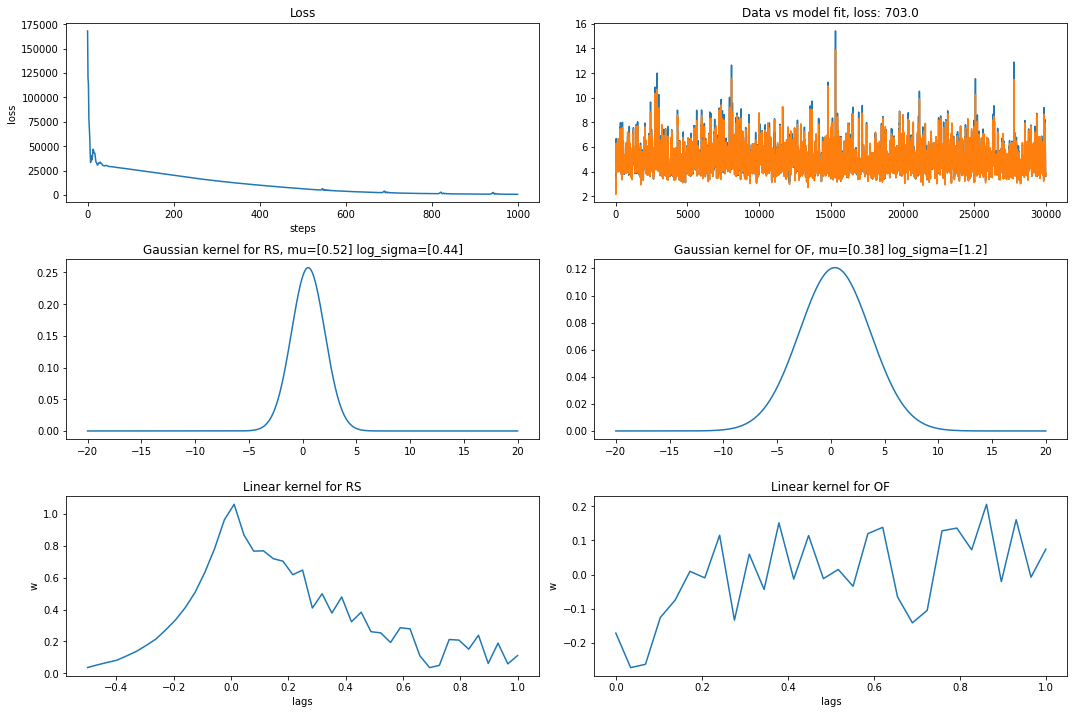

In [9]:
plt.figure(figsize=(15,10))
plt.subplot(321)
plt.plot(loss_history)
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('Loss')

plt.subplot(322)
plt.plot(spikes, label='Data')
plt.plot(mm.model.rs_of_integration.apply(params=params, rs=rs_x, of=of_x), label='Model fit')
plt.title('Data vs model fit, loss: ' +str(np.around(loss_history[-1])))

plt.subplot(323)
x_axis = np.arange(-20,20,0.001)
plt.plot(x_axis, scipy.stats.norm.pdf(x_axis, params['gaussian_module']['mu'], np.exp(params['gaussian_module']['log_sigma'])))
plt.title('Gaussian kernel for RS, mu='+str(np.round(np.array(params['gaussian_module']['mu']),2))+' log_sigma='+str(np.round(np.array(params['gaussian_module']['log_sigma']),2)))

plt.subplot(324)
plt.plot(x_axis, scipy.stats.norm.pdf(x_axis, params['gaussian_module_1']['mu'], np.exp(params['gaussian_module_1']['log_sigma'])))
plt.title('Gaussian kernel for OF, mu='+str(np.round(np.array(params['gaussian_module_1']['mu']),2))+' log_sigma='+str(np.round(np.array(params['gaussian_module_1']['log_sigma']),2)))

plt.subplot(325)
plt.plot(np.linspace(-0.5,1,int(frame_rate*(1-(-0.5)))),params['linear']['w'])
plt.xlabel('lags')
plt.ylabel('w')
plt.title('Linear kernel for RS')

plt.subplot(326)
plt.plot(np.linspace(0,1,int(frame_rate*(1-(0)))),params['linear_1']['w'])
plt.xlabel('lags')
plt.ylabel('w')
plt.title('Linear kernel for OF')

plt.tight_layout(pad=1)


In [281]:
import pickle
with open('params_sim.pickle', 'wb') as handle:
    pickle.dump(params, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('params_sim.pickle', 'rb') as handle:
    b = pickle.load(handle)
    